PyTorch functional ImageNet classification demo
==========

In [2]:
from PIL import Image
import requests
import numpy as np
from StringIO import StringIO
import hickle as hkl
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline

/home/zagoruys/anaconda2/lib/python2.7/site-packages/cffi/model.py:532: UserWarning: 'point_conversion_form_t' has no values explicitly defined; guessing that it is equivalent to 'unsigned int'
  % self._get_c_name())


### Pretrained weights

Load `hdf5` weights for Network-in-Network model

In [10]:
params = hkl.load('nin-export.hkl')

# convert numpy arrays to torch Variables
for k,v in sorted(params.iteritems()):
    print k, v.shape
    params[k] = Variable(torch.from_numpy(v))

conv0.bias (96,)
conv0.weight (96, 3, 11, 11)
conv1.bias (96,)
conv1.weight (96, 96, 1, 1)
conv10.bias (1024,)
conv10.weight (1024, 1024, 1, 1)
conv11.bias (1024,)
conv11.weight (1024, 1024, 1, 1)
conv2.bias (96,)
conv2.weight (96, 96, 1, 1)
conv3.bias (256,)
conv3.weight (256, 96, 5, 5)
conv4.bias (256,)
conv4.weight (256, 256, 1, 1)
conv5.bias (256,)
conv5.weight (256, 256, 1, 1)
conv6.bias (384,)
conv6.weight (384, 256, 3, 3)
conv7.bias (384,)
conv7.weight (384, 384, 1, 1)
conv8.bias (384,)
conv8.weight (384, 384, 1, 1)
conv9.bias (1024,)
conv9.weight (1024, 384, 3, 3)
fc.bias (1000,)
fc.weight (1000, 1024)


### Model definition

In [11]:
def f(inputs, params):
    def conv2d(x, params, name, stride=1, padding=0):
        return F.conv2d(x,
                        params['%s.weight'%name],
                        params['%s.bias'%name], stride, padding)

    def block(x, names, stride, padding):
        x = F.relu(conv2d(x, params, names[0], stride, padding))
        x = F.relu(conv2d(x, params, names[1]))
        x = F.relu(conv2d(x, params, names[2]))
        return x

    o = block(inputs, ['conv0', 'conv1', 'conv2'], 4, 5)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv3', 'conv4', 'conv5'], 1, 2)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv6', 'conv7', 'conv8'], 1, 1)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv9', 'conv10', 'conv11'], 1, 1)
    o = F.avg_pool2d(o, 7)
    o = o.view(o.size(0), -1)
    o = F.linear(o, params['fc.weight'], params['fc.bias'])
    return o

### Load an image

In [5]:
def load(url):
    response = requests.get(url)
    return np.ascontiguousarray(Image.open(StringIO(response.content)), dtype=np.uint8)

im = load('http://www.zooclub.ru/attach/26000/26132.jpg')

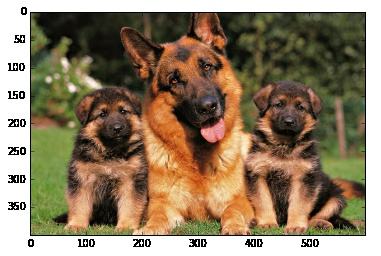

In [6]:
plt.imshow(im)

In [8]:
tr_center_crop = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [12]:
def classify(tensor):
    with open('synset_words.txt') as h:
        synset_words = [s[10:-1] for s in h.readlines()]

    probs, idx = F.softmax(f(Variable(tensor.unsqueeze(0), volatile=True), params)).data.view(-1).sort(0,True)

    s = ''
    for i in range(0,5):
        s += ('%.2f') % (probs[i]) + ': ' + synset_words[idx[i]] + '\n'
    print s

classify(tr_center_crop(im))

0.99: German shepherd, German shepherd dog, German police dog, alsatian
0.01: malinois
0.00: Norwegian elkhound, elkhound
0.00: Leonberg
0.00: red wolf, maned wolf, Canis rufus, Canis niger

